# Stock Forecasting w/ LSTM


`-- Leo Lonzarich, 12 January 2022 // [Revised 05-10-23] --`


### Table of Contents
- [Importing Stock Data](#import)
- [LSTM Model](#lstmmodel)
    - [Preprocessing](#preprocessing)
    - [Building](#build)
    - [Training](#train)
    - [Predictions](#preds)
- [Model Validation](#validation)
    - [Backtesting](#backtest)
    - [Moving Windows](#windows)


### Motivations:
- How accurately can we predict next-day and future equity prices?

- Is it useful to predict prices with multiple metrics, like beta?

- What is the financial risk of investing in a particular equity?

### General Comments:
- Using Long Short Term Memory (LSTM), an artificial recurrent neural network, to predict closing future stock closing performance.
    - LSTM works best when handeling large-scale datasets like these.
<br><br>
- Selecting past 60 days to make next-day predictions.

- This project, and the analysis herein, is meant only to be a supplemental tool alongside general intuition, good sense, analysis of financial climates, etc.

<br><br>

---
#### TO DO

- We are only using univariate stacked LSTM here. Try Bidirectional LSTM to see if it adds any explanatory power. (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

- Just as well, test modifications to model structure and activation functions (more/less dense and LSTM layers).

- Eventually incorporate contents into terminal-executable financial package, in combination with general analysis, that spits out all information needed about a stock at once.

- Consider Gated Recurrent Units (GRUs) for efficiency over LSTMs (https://arxiv.org/pdf/1412.3555v1.pdf_).

- Consider Autoencoder (AE) LSTM to enhance current model (https://machinelearningmastery.com/lstm-autoencoders/).

- Limit-test model. Where does it fail and why? (Already tested: small-cap stocks, SPY and correlated stocks -- model must be retrained to predict on other sectors.)

- Find out what the best number of lag days is, and adjust the number of future days predicted per model run. Perhaps this can be incorporated into Optuna optimization?

- Check dataSplit function; we want this func to be capable of removing data from the the end of a selected period so that there is no chance the model is seeing data it shouldn't (data leakage).

- Address issue of error incidence in subset of cases when model is run to predict future data. Either we have sneaky leakage in training (however, we data split is confirmed to not be mixing data), or there is something else at play.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam

import optuna

from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt
from dateutil.relativedelta import relativedelta
import pickle

# Yahoo API may have broken previous versions of pd_datareader,
# so this is a workaround.
yfin.pdr_override()
pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing Data<a class="anchor" id="import"></a>
---

We use yfinance here, with a pandas_datareader workaround to address loss support for yfinance API. 

For the purposes of this analysis, we will be using adjusted daily closing prices (versus closing price). Since we want to predict future stock performance, closing prices are the natural choice as a predictive metric. Furthermore adjusted price gives stock price after dividend payounts, stock splits, and/or additional share issues, resulting in a more realistic and data-rich representation of share value.

In [3]:
# Yahoo Finance stock scraping.
# **Careful with how many times you run this to avoid IP ban**
TICKER = 'AAPL'
START = dt.datetime(2012, 1, 1)
END = dt.datetime(2023, 1, 1) # dt.datetime.today().date()


stock = pdr.get_data_yahoo(TICKER, START, END).rename(columns= {'Adj Close': 'AdjClose'})
print(stock.shape[0], "unique points loaded with attributes: \n", stock.
      keys())
stock = stock.reset_index()

[*********************100%***********************]  1 of 1 completed
2768 unique points loaded with attributes: 
 Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')


In [3]:
stock

,Date,Open,High,Low,Close,AdjClose,Volume
0,2012-01-03,127.760002,128.380005,127.430000,127.500000,103.202309,193697900
1,2012-01-04,127.199997,127.809998,126.709999,127.699997,103.364189,127186500
2,2012-01-05,127.010002,128.229996,126.430000,128.039993,103.639404,173895000
3,2012-01-06,128.199997,128.220001,127.290001,127.709999,103.372292,148050000
4,2012-01-09,128.000000,128.179993,127.410004,128.020004,103.623245,99530200
...,...,...,...,...,...,...,...
2763,2022-12-23,379.649994,383.059998,378.029999,382.910004,381.454193,59857300
2764,2022-12-27,382.790009,383.149994,379.649994,381.399994,379.949921,51638200
2765,2022-12-28,381.329987,383.390015,376.420013,376.660004,375.227936,70911500
2766,2022-12-29,379.630005,384.350006,379.079987,383.440002,381.982178,66970900


Verifying that we indeed have the keys listed above, and making sure data is numeric and looks reasonable. (Note that the weekends and bank holidays are not included so we have $\sim$ 255 days each year.)

The descriptive statistics are included below to further confirm are what we might expect.

Lastly, we run a check to locate any NaNs in the data. We return False when none are found.

In [4]:
stock.tail()

,Date,Open,High,Low,Close,AdjClose,Volume
2763,2022-12-23,379.649994,383.059998,378.029999,382.910004,381.454193,59857300
2764,2022-12-27,382.790009,383.149994,379.649994,381.399994,379.949921,51638200
2765,2022-12-28,381.329987,383.390015,376.420013,376.660004,375.227936,70911500
2766,2022-12-29,379.630005,384.350006,379.079987,383.440002,381.982178,66970900
2767,2022-12-30,380.640015,382.579987,378.429993,382.429993,380.975983,84022200


In [5]:
# Use applymap to reduce tabular clutter.
stock.describe().applymap(lambda x: f"{x:0.3f}")

,Open,High,Low,Close,AdjClose,Volume
count,2768.000,2768.000,2768.000,2768.000,2768.000,2768.000
mean,261.657,263.079,260.096,261.689,241.129,100855994.762
std,91.598,92.264,90.830,91.577,98.097,49267039.109
min,127.010,127.810,126.430,127.500,103.202,20270000.000
25%,195.272,196.192,194.340,195.447,168.091,65951000.000
50%,242.935,244.145,241.890,243.110,219.918,89134700.000
75%,314.040,314.577,311.293,312.702,297.459,123494550.000
max,479.220,479.980,476.060,477.710,468.296,507244300.000


In [6]:
stock.isnull().values.any()

False

To really see what we are working with, let's plot the adjusted closing price below over the time frame we specified.

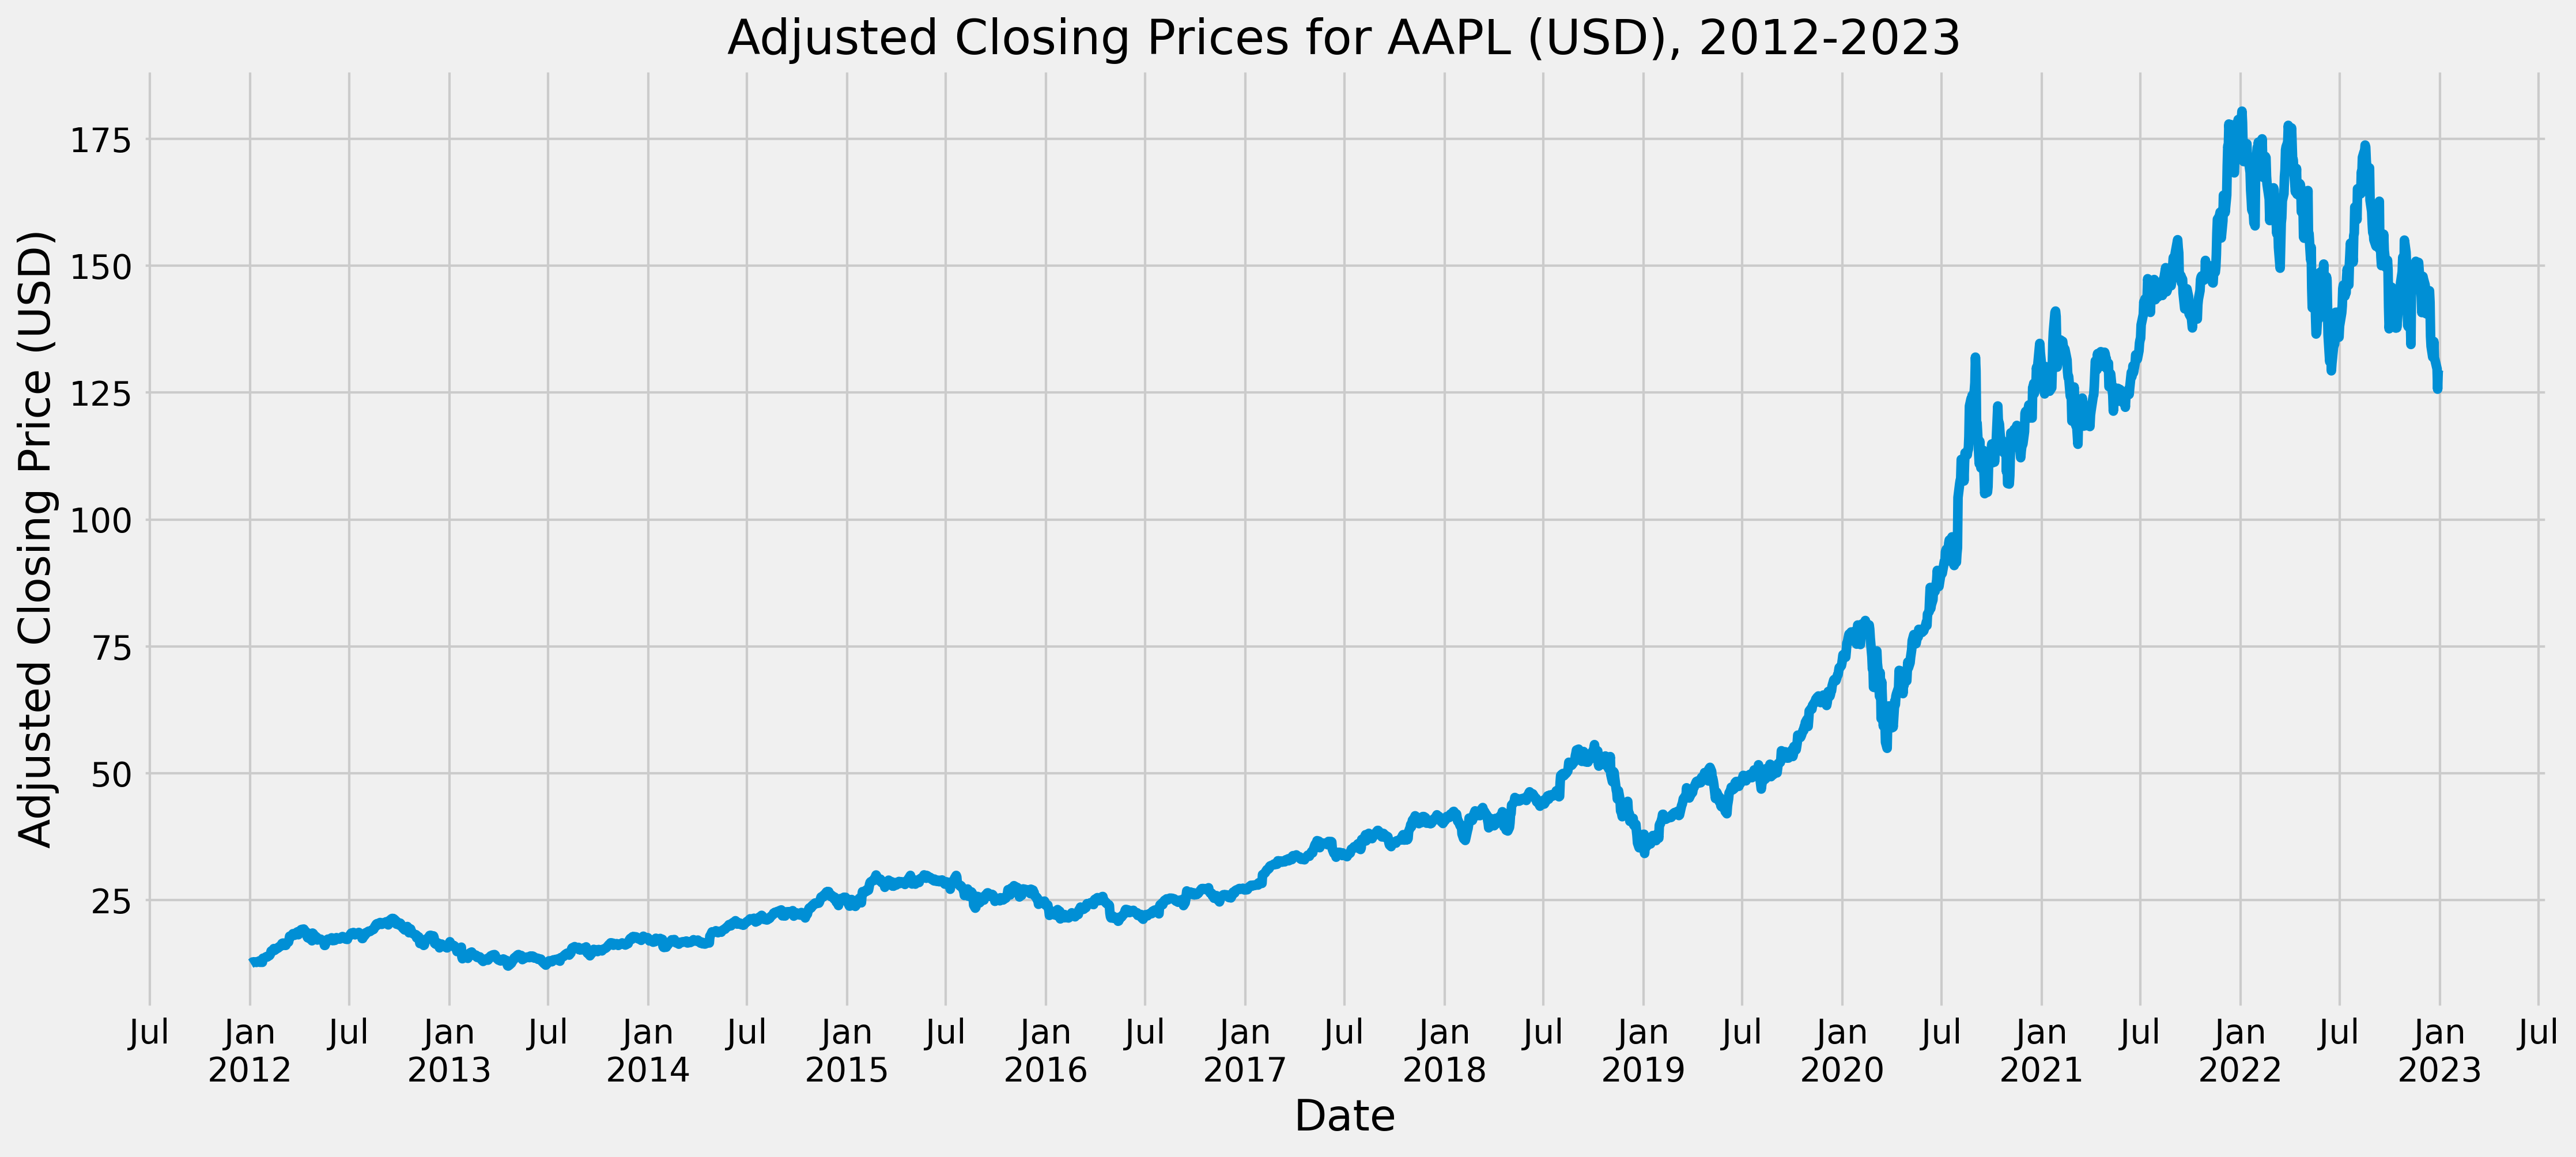

In [4]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.Date, stock.AdjClose)

ax.set_title('Adjusted Closing Prices for %s (USD), %s-%s' 
             %(TICKER, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
# ax.set_xlim(stock.Date.min(), stock.Date.max());

plt.show()

## LSTM RNN Model<a class="anchor" id="lstmmodel"></a>
---

We will use long short-term memory (LSTM) networks, a recurent neural network (Deep Learning). LSTM is especially useful here because it can learn long-term dependencies in time-series data and is surprisingly scalable and robust. See this article https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for a more detailed explanation of all the benefits this type of network offers.

We will first evaluate and univariate LSTM here, and then incorporate beta to assess the effectiveness of additional parameters in a separate section.

### Preprocessing:<a class="anchor" id="preprocessing"></a>

Building any good DL network starts with preprocessing. We will separate out the adjusted close prices, scale down numerical values to just around the origin (large numbers can lead to instabilities or otherwise slower gradient descent convergence), and make our train-test splits.

*** For the purposes of building/improving this package, we will start 2 years back from the end date in our stock data and predict the next day price from that date forward. Each next day prediction is set to use the previous 60 days of adjusted closing prices. Therefore, we should end up with approximately 75% of our predictions having been made solely using the model's own predictions. Though this appears sketchy on its face, predictions do not appear to falter once this takes place. (See the plot at the end of this modeling section.)

#### Converting Time Series to a Supervised Learning Problem:<a class="anchor" id="timeseriesconvert"></a>

For univariate time series where we are interested in next-step predictions, the lag observations (those that occur at prior timesteps) are used as inputs to give an output observation for the current timestep. In effect, observations (t1, t2, t3) are used to predict the observation at time t4. One can then step forward and use (t2, t3, t4) to predict t5, and so on, thereby we recast the time series as a supervised learning problem. 

For a ML model, $f$, to forecast like this it requires splitting our data into input and output features X and y, respectively, so that we can have $y=f(X)$. For example, noting the above, we could have X = (t1, t2, t3) and y = t4. Transforming from time series to supervised learning is not so trivial, but it can be achieved very quickly with `Keras.preprocessing.sequence.TimeseriesGenerator`. Unfortunately, `.preprocessing` is depreciated, so we will include another function below that performs similarly and leave `generator` commented.

(See https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/ for more.)


In [5]:
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
def data_split(data, lag=60, days=1, train_ratio=0.70,
               validation=False, backtest=False):
    """
    Prepping stock data for neural net; scaling down 
    values and making train-test split.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    # Selecting 'AdjClose' prices as input and target feature for time series.
    data_adj = data.filter(['AdjClose']).values

    # Scaling data. Ensures quicker convergence to solution.
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data_adj)

    # Splitting input features and target object, X and y.
    supervised_data = series_to_supervised(scaled_data, n_in=lag, n_out=days)
    X = supervised_data.loc[:, supervised_data.columns != 'var1(t)'] 
    y = supervised_data['var1(t)'] # Isolating target object.

    # Selecting converted data for train-test split.
    len_training = int(np.ceil(len(scaled_data) * train_ratio))

    X_train = X.iloc[0:len_training].to_numpy()
    y_train = y.iloc[0:len_training].to_numpy()
    # X_train, y_train = np.array(X_train), np.array(y_train)

    # Making validation/test split.
    if validation:
        len_valid = int((len(X) - len_training)/2)
        len_valid += len_training-60

        # We subtract lag days since they are needed to actually  
        X_valid = X.iloc[len_training-60:len_valid].to_numpy()
        y_valid = data_adj[len_training:len_valid]

        X_test = X.iloc[len_valid-60:].to_numpy()
        y_test = data_adj[len_valid:]

    else:
        X_test = X.iloc[len_training-60:].to_numpy()
        y_test = data_adj[len_training:]

    # Reshaping to obtain 3D reps (currently 2d) to pass into LSTM.
    # LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.
    X_train = np.reshape(X_train, (X_train.shape[0],
                                   X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0],
                                 X_test.shape[1], 1))

    if len(X_test) != len(y_test):
        raise Warning('X, y length mismatch.')
    
    if validation:
        X_valid = np.reshape(X_valid, (X_valid.shape[0],
                                       X_valid.shape[1], 1))
        return X_train, y_train, X_valid, y_valid, X_test, y_test, scaler
    
    elif backtest:
        return X, y, scaler

    elif not backtest and not validation:
        return X_train, y_train, X_test, y_test, scaler
    
    else:
        ValueError(
            "Cannot simultaneously perform 'backtest' and 'validation'."
            )
        exit()


# generator = TimeseriesGenerator(scaled_data, scaled_data, length=60, batch_size=1)

In [7]:
LAG = 60 # Number of days to use for predicting the following day(s).
DAYS = 1 # Number of days to predict with each lag period.
TRAIN_RATIO = 0.70 # Percent of data that will go to training
SPLIT_DATE = dt.datetime(2023, 1, 1) # Lower threshold for untouched valid data.

UNITS = 150
CLASSES = 50
BATCHSIZE= 128
EPOCHS = 10

# Data for testing on SVB collapse.
svb_validation = stock[stock.Date >= pd.Timestamp(SPLIT_DATE)]
# Data for training and validation.
stock_short = stock[stock.Date < pd.Timestamp(SPLIT_DATE)] 

split = data_split(stock_short, lag=LAG, days=DAYS, train_ratio=TRAIN_RATIO)

X_train, y_train = split[0], split[1]
X_test, y_test = split[2], split[3]
scaler = split[4]


In [8]:
X_train, y_train

(array([[[0.00269216],
         [0.0030905 ],
         [0.00391788],
         ...,
         [0.03797626],
         [0.03932816],
         [0.03989413]],
 
        [[0.0030905 ],
         [0.00391788],
         [0.00470556],
         ...,
         [0.03932816],
         [0.03989413],
         [0.0384954 ]],
 
        [[0.00391788],
         [0.00470556],
         [0.0045848 ],
         ...,
         [0.03989413],
         [0.0384954 ],
         [0.03663697]],
 
        ...,
 
        [[0.25110801],
         [0.24483333],
         [0.24649594],
         ...,
         [0.30480303],
         [0.30812376],
         [0.31369218]],
 
        [[0.24483333],
         [0.24649594],
         [0.24765259],
         ...,
         [0.30812376],
         [0.31369218],
         [0.3211314 ]],
 
        [[0.24649594],
         [0.24765259],
         [0.25064537],
         ...,
         [0.31369218],
         [0.3211314 ],
         [0.31563544]]]),
 array([0.0384954 , 0.03663697, 0.04007617, ..., 0.3211

### Building and Hyperparameter Tuning:<a class="anchor" id="build"></a>

The effectivenes of our model depends on a number of different parameters such the number of LSTM and Dense layers. To improve model accuracy, we build an objective function and use `Optuna` to locate optimized parameter combinations.

(See https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4 for param tuning.)

Optimization is run with the opt file `lstm_optimize.py`, which can be run in parallel with `run_parallel.sh` in Bash. Execution of the optimization procedure is left in the Python file, so for now we will simply import the results of a desired run; the best hyperparameters identified in each user-run optimization are stored in a pickle file in opt_cache. Using Optuna's API, we can pass these parameters to a modified `create_model` function, as below. 

In [9]:
def create_model(trial, in_shape):
    '''
    A modification on the vanilla function, where in
    this case we pass a trial object that Optuna uses both in
    its optimization routine, and for passing values for the
    hyperparameters in the case of model fitting.
    in_shape: int, gives the col shape (# of features) that the
        first LSTM node should expect to receive.
    '''
    units = trial.suggest_int('units', 64, 150, step=2)
    dropout = trial.suggest_float('dropout', 0, 1)
    classes = trial.suggest_int('classes', 13, 50, step=1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    # activation = trial.suggest_categorical('dense_activation', [None, 'tanh', 'sigmoid'])
    # recurrent_dropout = trial.suggest_float('recurrent_droupout', 0, 1)

    model = Sequential()
    model.add(
        LSTM(
            units=units,
            activation='tanh',
            recurrent_activation='sigmoid',
            unroll=False,
            use_bias=True,
            dropout=dropout,
            # recurrent_dropout=recurrent_dropout,
            return_sequences=True,
            input_shape=(in_shape, 1)
        )
    )
    model.add(
        LSTM(
            units=int(units/2),
            activation='tanh',
            recurrent_activation='sigmoid',
            unroll=False,
            use_bias=True,
            dropout=dropout,
            # recurrent_dropout=recurrent_dropout,
            return_sequences=False,
        )
    )
    model.add(
        Dense(
            classes,
            activation=None,
            use_bias=True
        )
    )
    model.add(
        Dense(
            1,
            activation= None, # activation,
            use_bias=True
        )
    )

    # Only use 'accuracy' metric for classification.
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(
            learning_rate=learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07
        ),
        metrics=['mean_squared_error'] # ['mean_absolute_percentage_error']
    )
    
    return model

In [10]:
# PATH = 'mape6'
PATH = 'OptStudy_AAPL'
filepath = '/Users/leoglonz/Desktop/stock_analysis/opt_cache/' + PATH + '.pickle'


study = pickle.load(open(filepath, 'rb'))
print("Number of finished trials: %i" %len(study.trials))
print("Best trial:")

best_trial = study.best_trial

print("    RMSE Value: %.3e" %best_trial.value)
print("    Params: ")
for key, value in best_trial.params.items():
    if value == str(value) or value == None:
        print("    %s: %s" %(key, value))
    else:
        print("    %s: %.3e" %(key, value))

Number of finished trials: 50
Best trial:
    RMSE Value: 5.592e+00
    Params: 
    batchsize: 1.000e+01
    epochs: 5.000e+00
    units: 1.480e+02
    dropout: 1.155e-01
    classes: 4.200e+01
    learning_rate: 7.961e-04


### Training Model: <a class="anchor" id="train"></a>

There are three metrics we will consider to measure LSTM model error: mean squared error (MSE), root MSE (RMSE), and mean absolute percentage error (MAPE). MAPE will give us a rough percentage error, while RMSE will give us an error in units of the features (in this case, USD). 

We will use RMSE most often for its interpretability by nature of it being in known units. However, we will use MSE when running the hyperparameter optimizer because MSE is much more suceptible to outliers -- meaning more sensitive during training -- and, therefore, may allow us greater accuracy in hyperparameter tuning.

In [11]:
in_shape = X_train.shape[1] # Number of input features.
model = create_model(best_trial, in_shape)

best_trial.params
model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        shuffle=True,
        batch_size=best_trial.params['batchsize'],
        epochs=best_trial.params['epochs'],
        verbose=True,
    )

2023-06-02 17:35:20.895960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-02 17:35:20.896330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Epoch 1/5


2023-06-02 17:35:21.316197: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-02 17:35:22.284740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:22.603507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:22.827521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:23.117838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:23.479107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - ETA: 0s - loss: 3.8748e-04 - mean_squared_error: 3.8748e-04

2023-06-02 17:35:33.114882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:33.216143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-02 17:35:33.363199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194/194 [==============================] - 14s 60ms/step - loss: 3.8748e-04 - mean_squared_error: 3.8748e-04 - val_loss: 16165.9229 - val_mean_squared_error: 16165.9229
Epoch 2/5
194/194 [==============================] - 10s 51ms/step - loss: 6.6251e-05 - mean_squared_error: 6.6251e-05 - val_loss: 16164.4570 - val_mean_squared_error: 16164.4570
Epoch 3/5
194/194 [==============================] - 10s 51ms/step - loss: 6.1231e-05 - mean_squared_error: 6.1231e-05 - val_loss: 16169.3721 - val_mean_squared_error: 16169.3721
Epoch 4/5
194/194 [==============================] - 10s 51ms/step - loss: 6.3897e-05 - mean_squared_error: 6.3897e-05 - val_loss: 16172.5625 - val_mean_squared_error: 16172.5625
Epoch 5/5
194/194 [==============================] - 10s 51ms/step - loss: 5.4447e-05 - mean_squared_error: 5.4447e-05 - val_loss: 16167.4082 - val_mean_squared_error: 16167.4082


### Predictions: <a class="anchor" id="preds"></a>

We need a point of comparison for future models, and so use RMSE to quantify model performance.

In the event we want to load a model already trained, we can identically reconstruct it with the lines below.

In [82]:
# filepath = '/Users/leoglonz/Desktop/stock_analysis/Models/'
# reconstructed_model = keras.models.load_model(filepath + PATH + '_model')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 148)           88800     
                                                                 
 lstm_1 (LSTM)               (None, 74)                66008     
                                                                 
 dense (Dense)               (None, 42)                3150      
                                                                 
 dense_1 (Dense)             (None, 1)                 43        
                                                                 
Total params: 158,001
Trainable params: 158,001
Non-trainable params: 0
_________________________________________________________________


In [14]:
y_preds = model.predict(X_test)
y_preds = scaler.inverse_transform(y_preds)

# Computing RMSE and MAPE.
rmse = np.sqrt(np.sum((y_test-y_preds)**2) / len(y_test))
mape = np.sum(np.abs((y_test-y_preds) / y_test)) / len(y_test)

print("Model RMSE: %.4f" %rmse)
print("MAPE: %.4f %%" %(100*mape))

26/26 [==============================] - 1s 21ms/step
Model RMSE: 6.8210
MAPE: 4.3047 %


We roughly visualize the results of our model in the plot below, where we include the actually adjusted close price history in blue (training) and red (validation), and the predictions overlayed in orange.

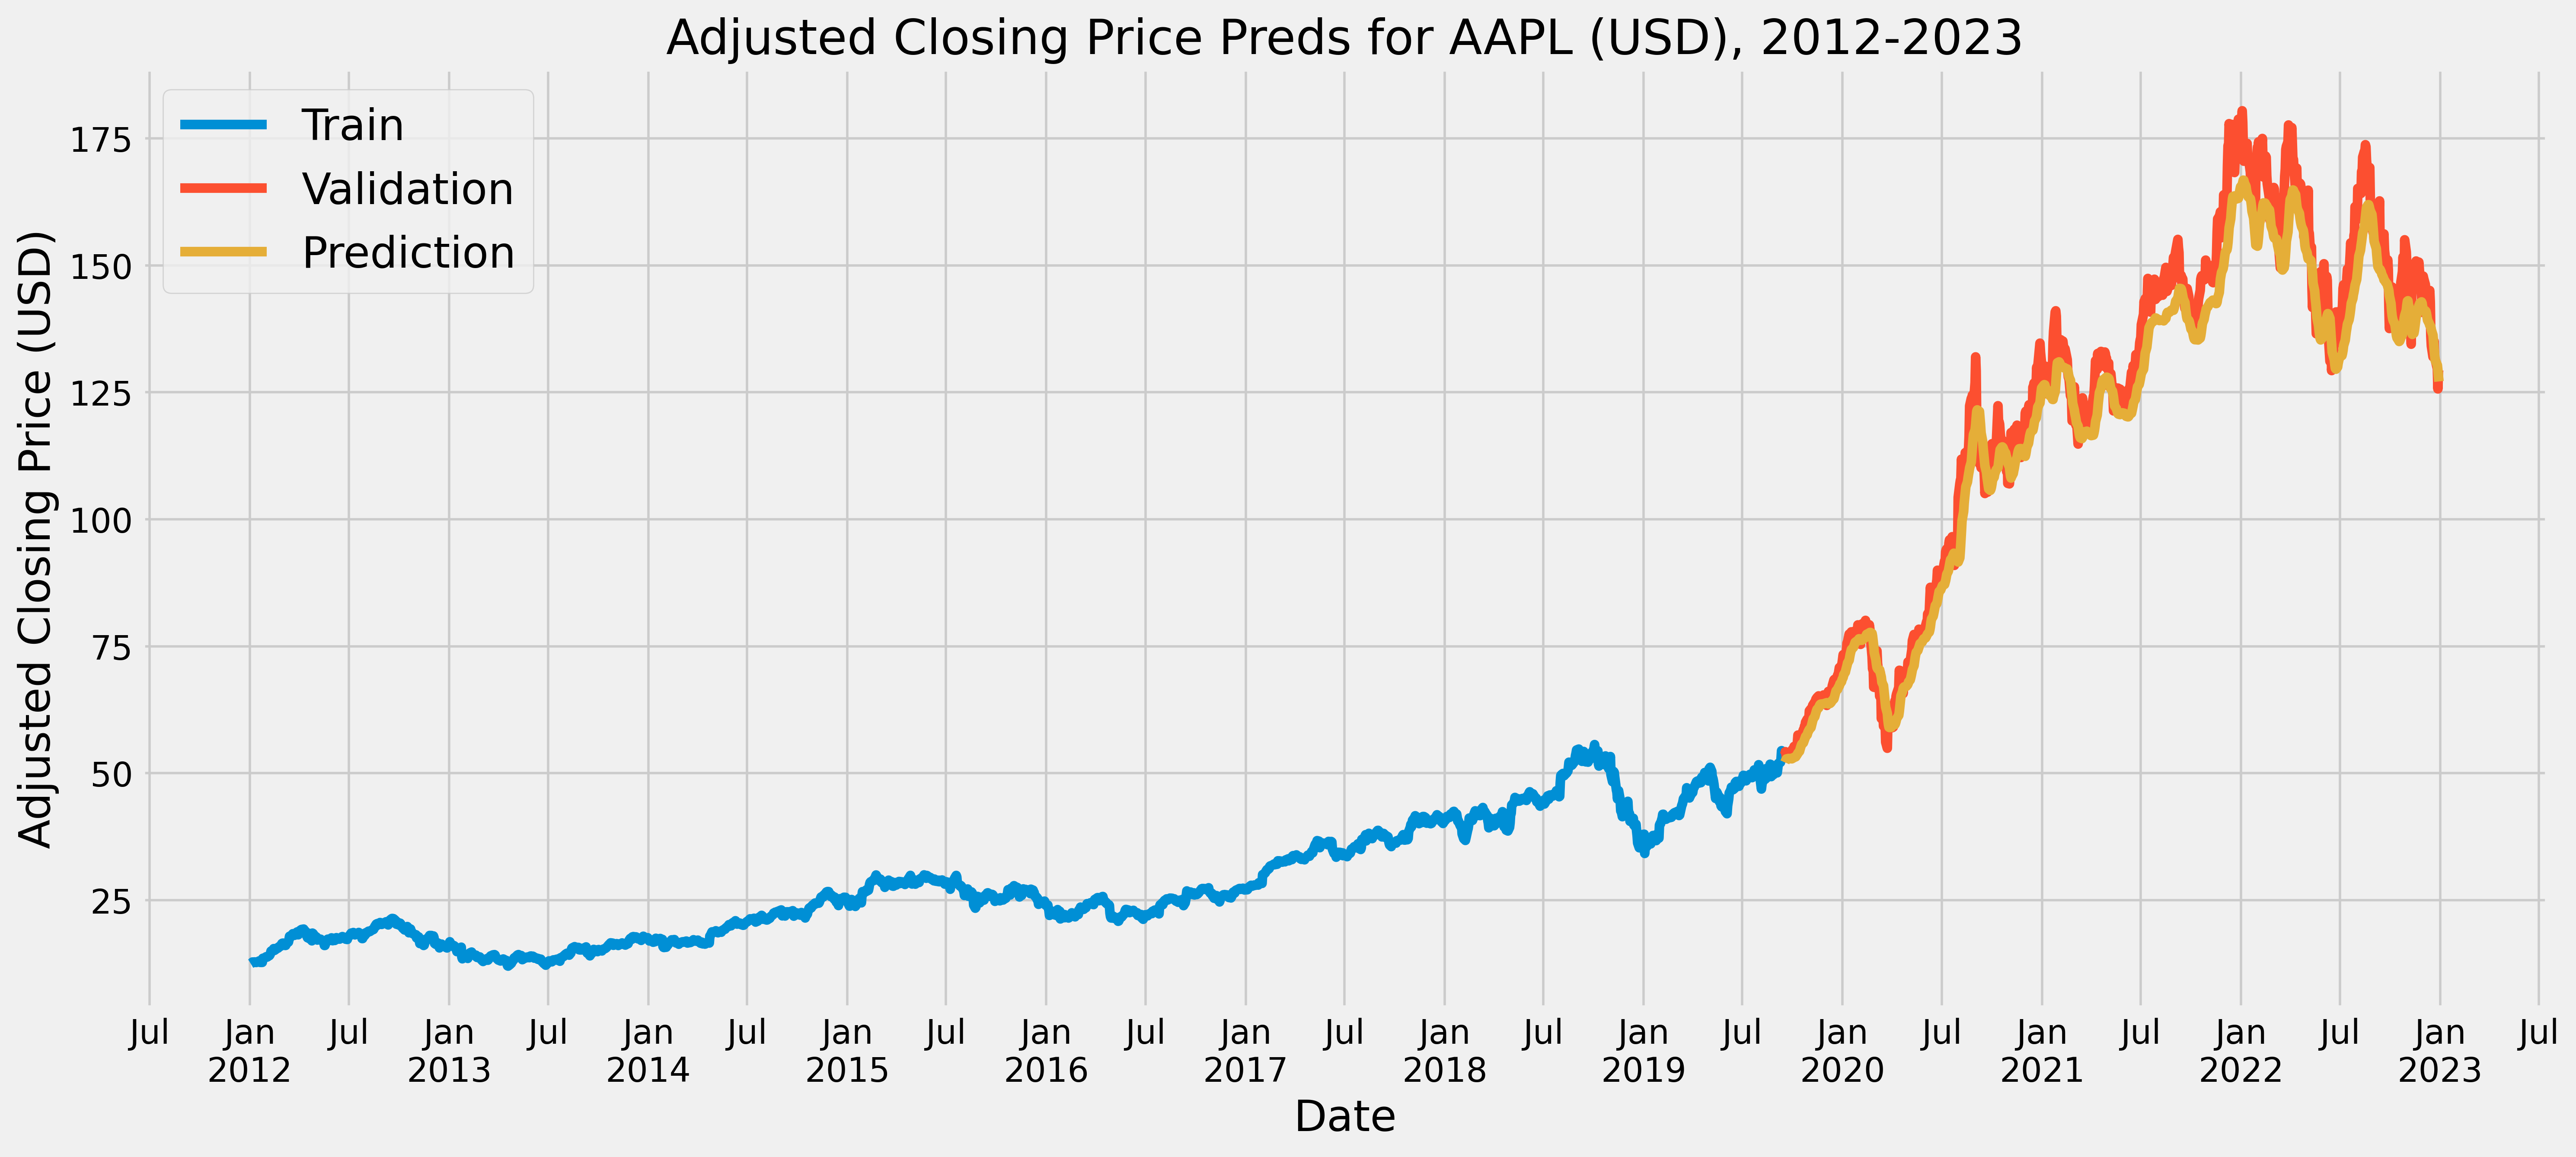

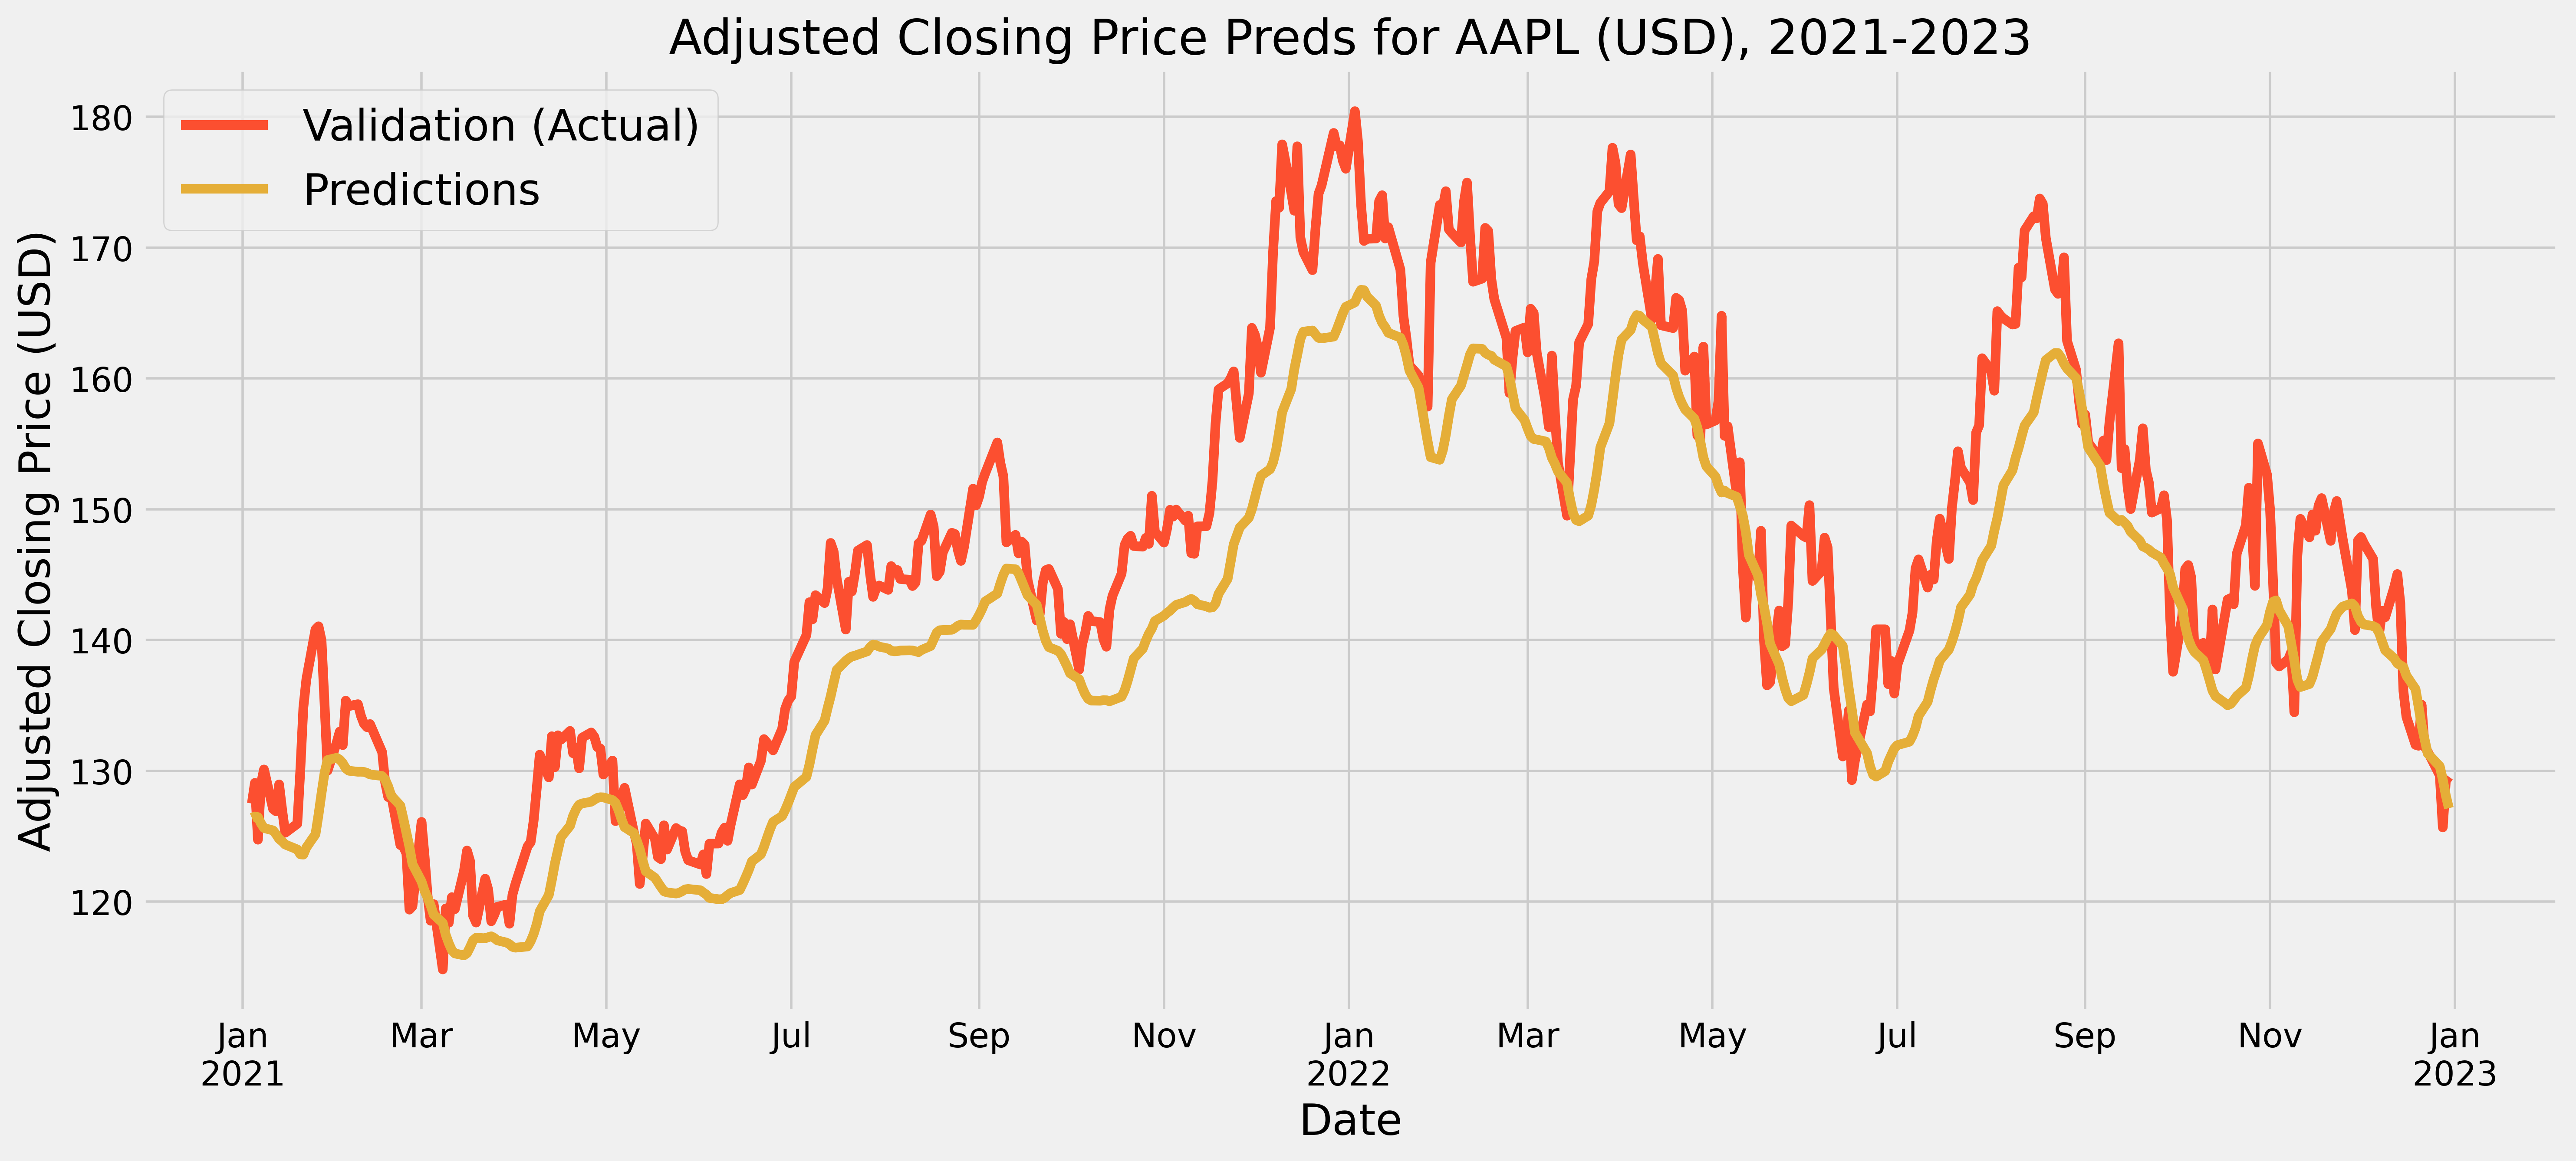

In [15]:
ZOOM = 2 # Number of years to get higher res for.

# Plotting results.
data = stock_short.filter(['Date', 'AdjClose'])

train = data[:len(X_train)]
valid = data[len(X_train):] # actual data that model predicted.
valid['Predictions'] = y_preds


fig, ax = plt.subplots(1,1, dpi=400, figsize=(16,8),
    constrained_layout=False)

ax.plot(train.Date, train.AdjClose, label='Train')
ax.plot(valid.Date, valid.AdjClose, label='Validation')
ax.plot(valid.Date, valid.Predictions, label='Prediction')

ax.set_title('Adjusted Closing Price Preds for %s (USD), %s-%s' 
             %(TICKER, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend(fontsize='18')

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
# ax.set_xlim(data.Date.min(), data.Date.max());


# Zoom-in Plot.
mid = END - relativedelta(years=ZOOM)
train_z = train[train.Date >= pd.Timestamp(mid)]
valid_z = valid[valid.Date >= pd.Timestamp(mid)]

fig, ax = plt.subplots(1,1, dpi=400, figsize=(16,8),
    constrained_layout=False) 

ax.plot(train_z.Date, train_z.AdjClose)
ax.plot(valid_z.Date, valid_z.AdjClose, label='Validation (Actual)')
ax.plot(valid_z.Date, valid_z.Predictions, label='Predictions')

ax.set_title('Adjusted Closing Price Preds for %s (USD), %s-%s' 
             %(TICKER, mid.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend(fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
# ax.set_xlim(data.Date.min(), data.Date.max());

plt.show()

Assuming we've just trained a model meeting our standards, we can save it to our model directory as below:

*Note the saved model will be named after the optimization run used to train its hyperparameters. This helps ensure continuity and organization among models and optimization runs.

In [86]:
# we us the PATH name of the optimizer file to keep t
# filepath = '/Users/leoglonz/Desktop/stock_analysis/Models/'
# model.save(filepath + PATH + '_model')

For another application, let us now test the model up and through the point when Silicon Valley Bank (SVB) collapsed to see if we can predict the prices of a few of its holdings through the banking turmoil.

To note, this is data that our model has never be seen, so success here is a good check that it is not simply memorizing data.

For this example, we rerun the data collection and training in the prior code cells so to obtain data and a historically trained model for e.g., Roku, TSMC. We plot the predictions following the collapse below to test effectiveness in unexpected market environments.

In [129]:
lag = 25

data_adj = svb_validation.filter(['AdjClose']).values
scaler_svb = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler_svb.fit_transform(data_adj)
supervised_data = series_to_supervised(scaled_data, n_in=lag, n_out=1)

X = supervised_data.loc[:, supervised_data.columns != 'var1(t)'] 
y = supervised_data['var1(t)'] # Isolating target object.

X_svb = supervised_data.loc[:, supervised_data.columns != 'var1(t)']
X_svb = X_svb.to_numpy()
X_svb = np.reshape(X_svb, (X_svb.shape[0], X_svb.shape[1], 1))

y_svb = data_adj[lag:]

In [130]:
y_preds = model.predict(np.asarray(X_svb))
y_preds = scaler_svb.inverse_transform(y_preds)

# Computing RMSE and MAPE.
rmse = np.sqrt(np.sum((y_svb-y_preds)**2) / len(y_svb))
mape = np.sum(np.abs((y_svb-y_preds) / y_svb)) / len(y_svb)

print("Model RMSE: %.4f" %rmse)
print("MAPE: %.4f %%" %(100*mape))

2023-03-30 21:27:18.710888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-30 21:27:18.805242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-30 21:27:18.909074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 106ms/step
Model RMSE: 0.8426
MAPE: 2.1789 %


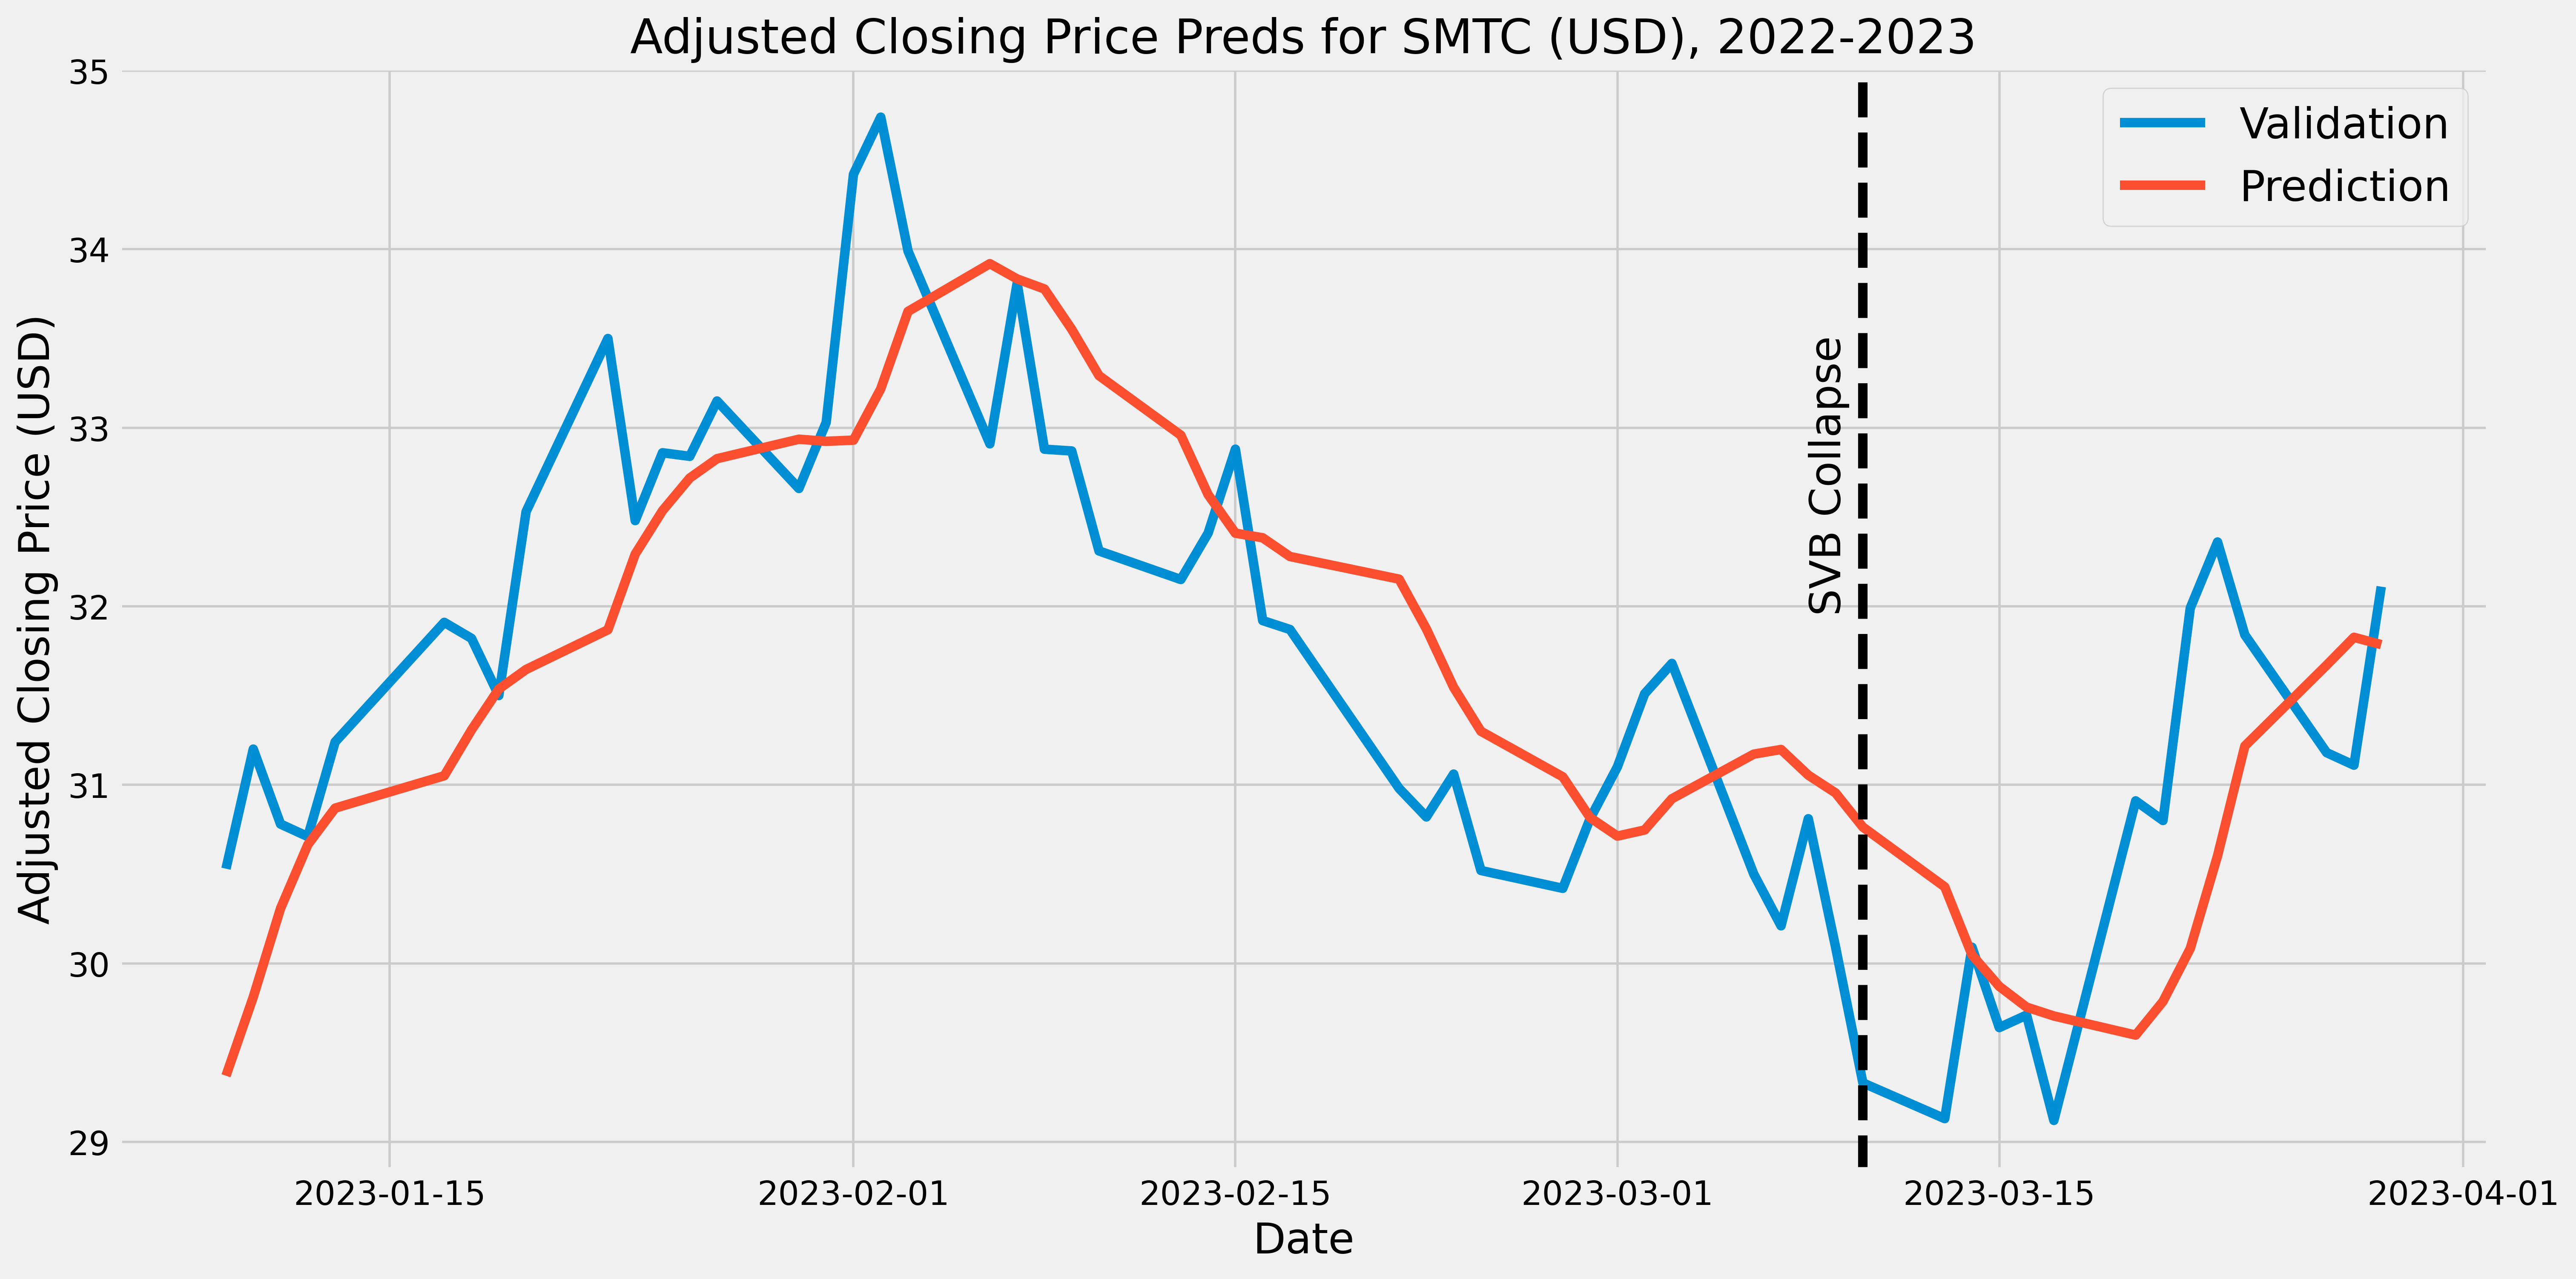

In [133]:
data_svb = svb_validation.filter(['Date', 'AdjClose']).iloc[lag:]
data_svb['Predictions'] = y_preds

fig, ax = plt.subplots(1,1, dpi=400, figsize=(16,8),
    constrained_layout=False)

ax.plot(data_svb.Date, data_svb.AdjClose, label='Validation')
ax.plot(data_svb.Date, data_svb.Predictions, label='Prediction')
ax.axvline(pd.Timestamp(dt.datetime(2023, 3, 10)), color='black', linestyle='--')

ax.set_title('Adjusted Closing Price Preds for %s (USD), %s-%s' 
             %(TICKER, SPLIT_DATE.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.text(pd.Timestamp(dt.datetime(2023, 3, 8)), 32, 'SVB Collapse',
        rotation=90, fontsize=18)

ax.legend(fontsize=18)

plt.show()

In the larger context of The entire dataset, model predictions look reasonable. However, when we zoom in on a few-year span, we start to see both lag in the predictions and flattening of actual price trends. For long term investing, this is not a concern, but efforts have been made to increase detection and prediction of peaks and valleys by:

1) Checking for overfitting (e.g., with backtesting),
2) Switching from `RMSE` loss to `MAE`. (RMSE heavily penalizes large deviations, and, therefore, results in training that keeps our model conservative.)

## Model Validation <a class="anchor" id="validation"></a>

---

### Backtesting: <a class="anchor" id="backtest"></a>

How do we know to place trust in our model? Typically we would do this with k-fold cross-validation, but such a technique requires assuming all observations are independent. 

Financial time series data is interdepenedent (neither independently nor identically distributed because of serial correlation and time-varying standard deviation; heteroskedasticity), however, and so we resort to walk-forward (cross) validation, which preserves temporal order.

To do this, we select a base window of observations to train the model on (starting from the first observation) and expand the window forward in time by one observation for every fold of the validation. (See diagram below.)

We perform the modeling process again with backtesting below.


![Walk-forward validation](Plots/walk-forward.png "Walk-forward Backtest Validation")

We also consider sliding window cross-validation here, which would have us keep a fixed window size and step forward, dropping older data. The benefit to using this blocked backtesting is that it may be reasonable to assume that the data from several years ago is not entirely representative of the current stock/market and, therefore, that it is not wise to use such data in making future observations.

However, since we are only looking at the last ~10 years of stock histories, the benefit of sliding windows may be limited. We should look into this more to confirm.

![Sliding-window validation](Plots/sliding-window.png "Sliding-window Backtest Validation")

(Photo credit: https://www.uber.com/blog/omphalos/)

In [312]:
class SlidingSeriesSplit():
    """
    parameters
    ----------
    n_test_folds: int
        number of folds to be used as testing at each iteration.
        by default, 1.
    """
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        if self.n_splits > n_samples:
            raise ValueError(
                "Cannot have number of folds =%i greater"
                " than the number of samples: %i." %(self.n_splits, n_samples))

        margin = 0
        for i in range(self.n_splits):
            # Sets the overlap of each block.
            start = i * int(k_fold_size/3)
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [313]:
def plot_cv_indices(cv, X, y, ax, n_splits, linewidth=10):
    """
    Plotting folds for walk forward-validation.
    """
    # Generate the training/testing visualizations for each CV split.
    for i, (train, test) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups.
        indices = np.array([np.nan]*len(X))
        indices[train] = 1
        indices[test] = 0

        ax.scatter(
            range(len(indices)),
            [i+1] * len(indices),
            c=indices, marker='_',
            cmap='coolwarm',
            linewidth=linewidth,
            vmin=-.2, vmax=1.2
            )

    # Formatting
    ax.set(
        yticks=np.arange(1,n_splits+1),
        xlabel="Historical Days Included",
        ylabel="CV Iteration",
        ylim=[n_splits+1.2, -.1]
        )
    ax.set_title("Walk-forward Splits for %i CV Iterations"
                 %n_splits, fontsize=15)
    ax.legend([Patch(color='tomato'), Patch(color='royalblue')],
          ['Train', 'Test'])
    
    return ax

We make and visualize the train-test splits for each CV pass below, in addition to displaying the number of samples for training and testing in each.

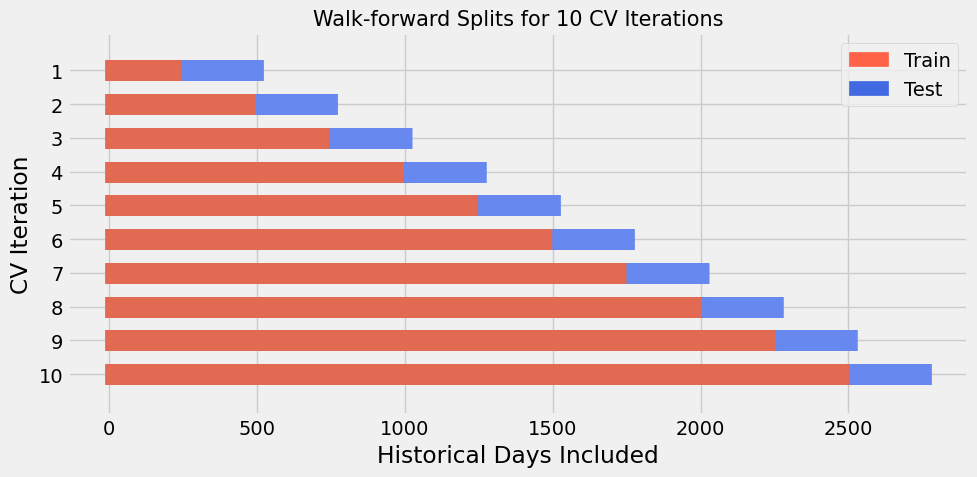

In [339]:
LAG = 60
DAYS = 1 
TRAIN_RATIO = 0.70
N_SPLITS = 10
STYPE = TimeSeriesSplit # SlidingSeriesSplit


data_adj = stock.filter(['AdjClose']).values

# Scaling data. Ensures quicker convergence to solution.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_adj)

# Splitting input features and target object, X and y.
supervised_data = series_to_supervised(scaled_data, n_in=LAG, 
                                       n_out=DAYS)
y = supervised_data['var1(t)'] # Isolating target object.
X = supervised_data.loc[:, supervised_data.columns != 'var1(t)'] 


series_split = STYPE(n_splits=N_SPLITS)
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(series_split, X, y, ax, N_SPLITS, 15)

plt.tight_layout()
plt.show()

In [315]:
'Training, Testing', [(el[0].shape, el[1].shape) 
                      for el in series_split.split(X)]

('Training, Testing',
 [((257,), (251,)),
  ((508,), (251,)),
  ((759,), (251,)),
  ((1010,), (251,)),
  ((1261,), (251,)),
  ((1512,), (251,)),
  ((1763,), (251,)),
  ((2014,), (251,)),
  ((2265,), (251,)),
  ((2516,), (251,))])

### Running Window Validation: <a class="anchor" id="windows"></a>

We start by making a rolling or expanding window split with `SlidingSeriesSplit` or `TimeSeriesSplit`, respectively, and read out the indicies used in each fold below.

Following this, we train seperate models on each fold and take the mean on the RMSEs for each. This is returned and interpreted as an aggregate error.

In our case, it's best to use rolling window testing, as it turns out closing prices are not as useful the older they become relative to the next-day prediction we are making. This can be verified simply by running backtesting use both the rolling and expanding window testing side by side. 

One explanation for this phenomenon might be that even just within the span of a few years, markets, politics, social temprements, and so on are subject to change -- enough of which uniquely influences stock prices. This is a sign that we might not in fact want more data, but only that which is reasonably recent relative to the day we are attempting to predict.

In [316]:
def backtest_split(data, lag=60, days=1, train_ratio=0.70,
                   n_splits=5, method=TimeSeriesSplit, verbose=False):
    """
    Splitting data for backtesting using either rolling or
    expanding window.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    series_split = method(n_splits=n_splits)

    # Separating input and target features in data.
    X, y, scaler = data_split(data, lag=lag, days=days, 
                              train_ratio=train_ratio, backtest=True)

    X = np.asarray(X) # series_split requires np arrays.
    y = np.asarray(y)

    if verbose:
        for fold, (train_index, test_index) in enumerate(series_split.split(X, y)):
            print("Fold: {}".format(fold))
            print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
            print("\n")
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
    return X, y, series_split, scaler


def backtest_validation(data, make_model, trial=None, lag=60, days=1,
                        train_ratio=0.7, n_splits=5, batch_size=1,
                        epochs=1, method=TimeSeriesSplit, verbose=False): 
    """
    Performing rolling or expanding window backtest
    validation for time series data that cannot be
    subjected to the typical procedure of cross validation.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    # Fetching feature split and backtest method.
    prams = backtest_split(data, lag=lag, days=days,
                           train_ratio=train_ratio, n_splits=n_splits,
                           method=method, verbose=False)
    
    X, y = prams[0], prams[1]
    series_split, scaler = prams[2], prams[3]
    
    agg_rmse = np.zeros(n_splits) # Initializing; collects all model RMSEs.

    for i, (train_index, test_index) in enumerate(series_split.split(X, y)):
        if verbose:
            print("[Start fold %i/%i]" %(i+1, n_splits))

        # Collect train and test data for the fold.
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build new model for the fold.
        model = None
        in_shape = X_train.shape[1]
        
        if trial==None:
            model = make_model(in_shape)
        else:
            # We pass a trial object with the best hyperparams from Optuna.
            model = make_model(trial, in_shape)

        model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            shuffle=True,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
        )

        # Calculate the fold's RMSE.
        y_preds = model.predict(X_test)
        y_preds = scaler.inverse_transform(y_preds)
        rmse = np.sqrt(np.sum((y_test-y_preds)**2) / len(y_test))

        if verbose:
            print("Loss for fold %i: %.3e" %(i+1, rmse))

        agg_rmse[i] = rmse

    return agg_rmse

In [317]:
BATCHSIZE = 1
EPOCHS = 1
N_SPLITS = 5

agg_rmse = backtest_validation(
    stock, 
    make_model=create_model,
    trial=best_trial,
    n_splits=N_SPLITS, 
    batch_size=best_trial.params['batchsize'],
    epochs=best_trial.params['epochs'],
    method=SlidingSeriesSplit,
    verbose=True
    )

print(agg_rmse)
print("Average Loss: %.3e (+/- %.3e)" %(agg_rmse.mean(),
                                           agg_rmse.std()))

[Start fold 1/2]
Epoch 1/8


2023-03-29 16:41:28.285641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:41:28.549779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:41:28.666952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:41:28.838828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:41:29.133220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1106/1106 [==============================] - ETA: 0s - loss: 4.7144e-05 - mean_squared_error: 4.7144e-05

2023-03-29 16:42:04.892202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:42:04.987902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 16:42:05.106744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1106/1106 [==============================] - 42s 37ms/step - loss: 4.7144e-05 - mean_squared_error: 4.7144e-05 - val_loss: 3.9747e-05 - val_mean_squared_error: 3.9747e-05
Epoch 2/8
1106/1106 [==============================] - 43s 39ms/step - loss: 2.2598e-05 - mean_squared_error: 2.2598e-05 - val_loss: 3.0246e-05 - val_mean_squared_error: 3.0246e-05
Epoch 3/8
1106/1106 [==============================] - 839s 760ms/step - loss: 2.0499e-05 - mean_squared_error: 2.0499e-05 - val_loss: 2.5352e-05 - val_mean_squared_error: 2.5352e-05
Epoch 4/8
1106/1106 [==============================] - 152s 138ms/step - loss: 1.5830e-05 - mean_squared_error: 1.5830e-05 - val_loss: 2.7994e-05 - val_mean_squared_error: 2.7994e-05
Epoch 5/8
1106/1106 [==============================] - 719s 650ms/step - loss: 1.5540e-05 - mean_squared_error: 1.5540e-05 - val_loss: 1.0988e-05 - val_mean_squared_error: 1.0988e-05
Epoch 6/8
1106/1106 [==============================] - 1690s 2s/step - loss: 1.4555e-05 - mean_squa

2023-03-29 18:57:15.897101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:15.996066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 4s

2023-03-29 18:57:16.132708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 58ms/step
Loss for fold 1: 5.189e+02
[Start fold 2/2]
Epoch 1/8


2023-03-29 18:57:17.729642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:18.073798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:18.247811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:18.571983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:19.122781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1105/1106 [============================>.] - ETA: 0s - loss: 1.3710e-04 - mean_squared_error: 1.3710e-04

2023-03-29 18:57:56.273027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:56.368006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 18:57:56.487527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1106/1106 [==============================] - 45s 38ms/step - loss: 1.3699e-04 - mean_squared_error: 1.3699e-04 - val_loss: 1.8781e-04 - val_mean_squared_error: 1.8781e-04
Epoch 2/8
1106/1106 [==============================] - 40s 36ms/step - loss: 4.7338e-05 - mean_squared_error: 4.7338e-05 - val_loss: 1.3451e-04 - val_mean_squared_error: 1.3451e-04
Epoch 3/8
1106/1106 [==============================] - 40s 36ms/step - loss: 4.1396e-05 - mean_squared_error: 4.1396e-05 - val_loss: 1.2773e-04 - val_mean_squared_error: 1.2773e-04
Epoch 4/8
1106/1106 [==============================] - 40s 36ms/step - loss: 3.5947e-05 - mean_squared_error: 3.5947e-05 - val_loss: 7.3378e-05 - val_mean_squared_error: 7.3378e-05
Epoch 5/8
1106/1106 [==============================] - 40s 36ms/step - loss: 3.1286e-05 - mean_squared_error: 3.1286e-05 - val_loss: 9.4753e-05 - val_mean_squared_error: 9.4753e-05
Epoch 6/8
1106/1106 [==============================] - 39s 35ms/step - loss: 2.7375e-05 - mean_squared_er

2023-03-29 19:02:39.430122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-29 19:02:39.521358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 4s

2023-03-29 19:02:39.644899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 45ms/step
Loss for fold 2: 7.570e+02
[518.93431243 757.04696369]
Average Loss: 6.380e+02 (+/- 1.191e+02)


Knowing that cross-validation -- and backtesting by proxy -- is pessimistic by default, we should expect larger average loss with this method than the RMSE found during initial model training. 

Furthermore, since these values are relative, experience running different models and hyperparameters goes to show that we can deem a model reasonable if its RMSE and average backtesting loss fall with the boundaries laid out as follows:

- RMSE: < 1.00
- Backtest Loss < 10.00

This said, achieving these thresholds largely depends on whether or not we are optimizing hyperparameters using backtest loss as a target metric for Optuna to minimize. Assuming we use backtesting -- `SlidingWindow` in particualar -- we can expect to reach these targets. However, using RMSE alone as a target has historically yielded mixed results.


## Work In Progress <a class="anchor" id="wip"></a>

----


### Multivariate LSTM Test:

See https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [114]:
# consolidating 'Close' prices to one stock.

# data = datFull.filter(['AdjClose', 'beta']).values
# len_training = math.ceil(len(data) * 0.8)

# # scaling data. Ensures quicker convergence to solution.
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data)

# # scaled training data.
# train_data = scaled_data[0:len_training,:]

# x_train = [] # features
# y_train = [] # desired prediction

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# # reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# # LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




# # using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
# model = Sequential()

# model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error') # use categorical crossentropy for categories.




# model.fit(x_train, y_train, batch_size=1, epochs=1)



# # Creating test data w/ scaled values.
# test_data = scaled_close[len_training - 60:, :]

# x_test = []
# y_test = close[len_training:, :]
# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])
    
# x_test = np.array(x_test)

# # reshaping 2d x_test into 3d.
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)

# # computing error.
# rmse = np.sqrt(np.mean(predictions - y_test)**2)

# print("Model error: %.4f" %rmse)







---

In [1]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime

import requests_cache

In [2]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = 'DEFAULT_HEADERS'

/var/folders/5l/9brv6cdn1b97f82knqyjcb4m0000gn/T/ipykernel_13015/389028320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


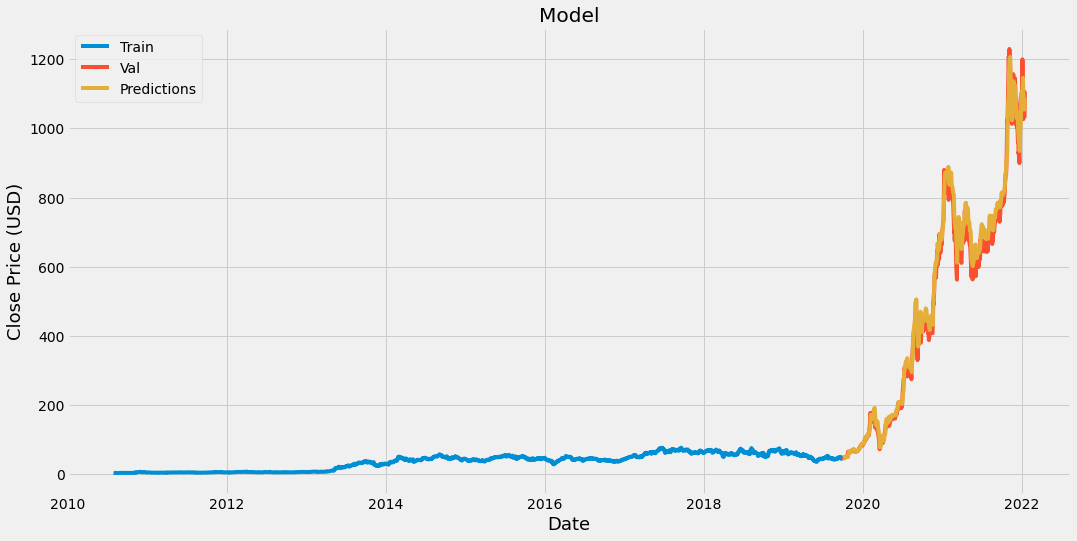

In [15]:
# plotting results.
data = df.filter(['Close'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)

plt.legend(['Train', 'Val', 'Predictions'])

plt.show()